# Assignment-3: Apply K-NN on Amazon Fine Food Reviews DataSet 

# 1.0 Introduction 

(i).The k-nearest neighbors algorithm (k-NN) is a non-parametric method used for classification and regression predictive problem.

(ii).It is more widely used in classification problems in the industry. 

# 2.0 Objective

To Predict the Polarity of Amazon Fine Food Review Using K-Nearst Neighbour Algorithm.

# 3.0 Importing All Required Library

In [1]:
%matplotlib inline
import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score

from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import TimeSeriesSplit

from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import cross_val_score
from sklearn import preprocessing

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os
import warnings
warnings.filterwarnings("ignore")

C:\Users\User\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


# 4.0 Importing Amazon Fine Food Review  Dataset

In [2]:
if os.path.isfile("final.sqlite"):
    conn=sqlite3.connect("final.sqlite")
    Data=pd.read_sql_query("select * from Reviews where Score!=3",conn)
    conn.close()
else :
    print("Error Importing the file")

In [3]:
# Printing some data of DataFrame

Data['Score'].value_counts()

1    307061
0     57110
Name: Score, dtype: int64

# 5.0 Information About DataSet

In [4]:
print("\nNumber of Reviews: ",Data["Text"].count())
print("\nNumber of Users: ",len(Data["UserId"].unique())) # Unique returns 1-D array of unique values of DataFrame.
print("\nNumber of Products: ",len(Data["ProductId"].unique()))
print("\nShape of Data: ", Data.shape)
print("\nColumn Name of DataSet : ",Data.columns)
print("\n\nNumber of Attributes/Columns in data: 12") 
print("\nNumber of Positive Reviews : ", Data['Score'].value_counts()[1])
print("\nNumber of Negative Reviews : ", Data['Score'].value_counts()[0])


Number of Reviews:  364171

Number of Users:  243414

Number of Products:  65442

Shape of Data:  (364171, 12)

Column Name of DataSet :  Index(['index', 'Id', 'ProductId', 'UserId', 'ProfileName',
       'HelpfulnessNumerator', 'HelpfulnessDenominator', 'Score', 'Time',
       'Summary', 'Text', 'CleanedText'],
      dtype='object')


Number of Attributes/Columns in data: 12

Number of Positive Reviews :  307061

Number of Negative Reviews :  57110


In [5]:
print("\nNumber of Reviews: ",Data["Text"].count())


Number of Reviews:  364171


### 5.1  Attribute Information About DataSet

1.Id - A unique value starts from 1



2.ProductId - A unique identifier for the product



3.UserId - A unqiue identifier for the user



4.ProfileName - Name of user profile 



5.HelpfulnessNumerator - Number of users who found the review helpful



6.HelpfulnessDenominator - Number of users who indicated whether they found the review helpful or not



7.Score - Rating 0 or 1



8.Time - Timestamp for the review



9.Summary - Brief summary of the review



10.Text - Text of the review



11.Cleaned Text - Text that only alphabets

## Taking  5K data for Brute Force and 2K data for KD Tree

In [6]:
# To randomly sample 10k points from both class
data = Data.sample(n = 50000)
data1= Data.sample(n=20000)


In [7]:
print("Number of positve and negative score in 50K Data Points")
print(data['Score'].value_counts())

print("\nNumber of positve and negative score in 20K Data Points")
print(data1['Score'].value_counts())


Number of positve and negative score in 50K Data Points
1    42303
0     7697
Name: Score, dtype: int64

Number of positve and negative score in 20K Data Points
1    16883
0     3117
Name: Score, dtype: int64


In [8]:
# Sorting on the basis of Time Parameter
data.sort_values('Time',inplace=True)
data1.sort_values('Time',inplace=True)

In [9]:
data.to_csv("50K_Data.csv",index=False)
data1.to_csv("20K_Data.csv",index=False)

In [9]:
Y = data['Score'].values
X = data['CleanedText'].values

Y1 = data1['Score'].values
X1 = data1['CleanedText'].values

###  7.0 Splitting DataSet into Train and Test Data

In [10]:
from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, shuffle=Flase): this is for time series split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33) # this is random splitting
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, Y1, test_size=0.33)

print("Shape of Train and Test Dataset for 50k points")
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

print("\nShape of Train and Test Dataset for 20k points")
print(X1_train.shape, y1_train.shape)
print(X1_test.shape, y1_test.shape)

Shape of Train and Test Dataset for 50k points
(33500,) (33500,)
(16500,) (16500,)

Shape of Train and Test Dataset for 20k points
(13400,) (13400,)
(6600,) (6600,)


# 8.0 Defining Some Function

### 8.1 Train Data Confusion Matrix Plot

In [11]:
def trainconfusionmatrix(knn,X_train,y_train):
    print("Confusion Matrix for Train set")
    cm=confusion_matrix(y_train, knn.predict(X_train))
    class_label = ["negative", "positive"]
    df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
    sns.heatmap(df_cm, annot = True, fmt = "d")
    plt.title("Train Confusiion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

### 8.2 Test Data Confusion Matrix Plot

In [12]:
def testconfusionmatrix(knn,X_test,y_test):
    print("Confusion Matrix for Test set")
    cm=confusion_matrix(y_test, knn.predict(X_test))
    class_label = ["negative", "positive"]
    df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
    sns.heatmap(df_cm, annot = True, fmt = "d")
    plt.title("Test Confusiion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

### 8.3 ROC-AUC Curve Plot

In [13]:
def plot_auc_roc(knn,X_train,X_test,y_train,y_test):
    train_fpr, train_tpr, thresholds = roc_curve(y_train, neigh.predict_proba(X_train)[:,1])
    test_fpr, test_tpr, thresholds = roc_curve(y_test, neigh.predict_proba(X_test)[:,1])

    plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
    plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
    plt.legend()
    plt.xlabel("K: hyperparameter")
    plt.ylabel("AUC")
    plt.title("ROC CURVE PLOTS")
    plt.show()

### 8.4 Error Plot

In [14]:
def error_plot(neighbours,mse):
    plt.title('Error Plot')
    plt.xlabel('K')
    plt.ylabel('misscalssifiaction error')
    plt.plot(neighbours,mse)

### 8.5 Cross Validation Using Kd Tree Algorithm

In [15]:
def knn_cv_kd(X_train,y_train,neighbours):
    
    cv_scores=[]
    tscv = TimeSeriesSplit(n_splits=10)
    
    for k in neighbours:
        knn = KNeighborsClassifier(n_neighbors=k,algorithm='kd_tree')
        scores = cross_val_score(knn, X_train, y_train, cv=tscv,scoring='roc_auc') # returns accuracy for each of 10 folds
        cv_scores.append(scores.mean())
        
    mse = [1-x for x in cv_scores] # calculating misscalssification_error = 1 - accuracy for each K
    
    best_k = neighbours[mse.index(min(mse))] #returns k corresponding to minimum error
    
    return mse,best_k

### 8.6 Cross Validation Using Brute Algorithm 

In [26]:
def knn_cv_brute(X_train,y_train,neighbours):
    
    cv_scores=[]
    tscv = TimeSeriesSplit(n_splits=10)
    
    for k in neighbours:
        knn = KNeighborsClassifier(n_neighbors=k,algorithm='brute')
        scores = cross_val_score(knn, X_train, y_train, cv=tscv,scoring='roc_auc') # returns accuracy for each of 10 folds
        cv_scores.append(scores.mean())
        
    mse = [1-x for x in cv_scores] # calculating misscalssification_error = 1 - accuracy for each K
    
    best_k = neighbours[mse.index(min(mse))] #returns k corresponding to minimum error
    
    return mse,best_k

# 9.0 Bags of Words

In [17]:
vectorizer = CountVectorizer()
vectorizer.fit(X_train) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_bow = vectorizer.transform(X_train)
X_train_bow=preprocessing.normalize(X_train_bow)

X_test_bow = vectorizer.transform(X_test)
X_test_bow=preprocessing.normalize(X_test_bow)

print("Shape of Train , Test and Cross Validation Data After vectorizations")
print(X_train_bow.shape, y_train.shape)
print(X_test_bow.shape, y_test.shape)

Shape of Train , Test and Cross Validation Data After vectorizations
(33500, 22818) (33500,)
(16500, 22818) (16500,)


In [18]:
type(X_train_bow)

scipy.sparse.csr.csr_matrix

### 9.1 Brute Force Algorithm

#### 9.1.1  Finding Optimal Value of Hyperparameter(k) 

In [27]:
import numpy as np 

neighbours=np.arange(1,100,2)
mse,best_k = knn_cv_brute(X_train_bow,y_train,neighbours)

Best value of K found for Brute Force Algorithm Implementaion is :  95


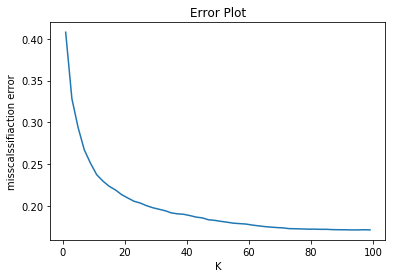

In [28]:
error_plot(neighbours,mse)
print("Best value of K found for Brute Force Algorithm Implementaion is : ",best_k)

#### 9.1.2 Training the model 

In [29]:
neigh = KNeighborsClassifier(n_neighbors = best_k,algorithm='brute')
neigh.fit(X_train_bow, y_train)

KNeighborsClassifier(algorithm='brute', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=95, p=2,
           weights='uniform')

#### 9.1.3 Evaluting the performance of model

##### (A). Roc-Auc Plot 

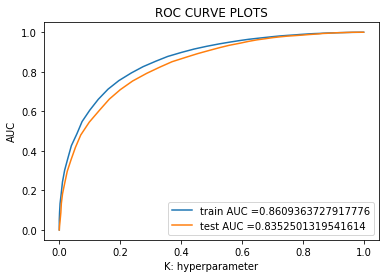

In [30]:
plot_auc_roc(neigh,X_train_bow,X_test_bow,y_train,y_test)

##### (B). Confusion Matrix Plot on Train Data 

Confusion Matrix for Train set


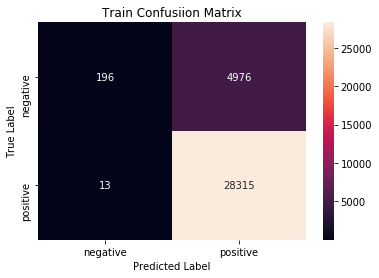

In [31]:
trainconfusionmatrix(neigh,X_train_bow,y_train)

##### (C). Confusion Matrix on Test Data 

Confusion Matrix for Test set


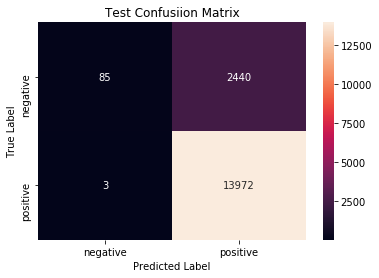

In [32]:
testconfusionmatrix(neigh,X_test_bow,y_test)

##### (D). Classification Report

In [33]:
print("Classification Report: \n")
y_pred=neigh.predict(X_test_bow)

print(classification_report(y_test, y_pred))


Classification Report: 

              precision    recall  f1-score   support

           0       0.97      0.03      0.07      2525
           1       0.85      1.00      0.92     13975

   micro avg       0.85      0.85      0.85     16500
   macro avg       0.91      0.52      0.49     16500
weighted avg       0.87      0.85      0.79     16500



###  9.2 KD-Tree Algorithm

#### 9.2.1 Finding Optimal Value of Hyperparameter(k)

In [34]:
vectorizer = CountVectorizer()
vectorizer.fit(X1_train) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X1_train_bow = vectorizer.transform(X1_train)
X1_train_bow=preprocessing.normalize(X1_train_bow)

X1_test_bow = vectorizer.transform(X1_test)
X1_test_bow=preprocessing.normalize(X1_test_bow)

print("Shape of Train , Test and Cross Validation Data After vectorizations")
print(X1_train_bow.shape, y1_train.shape)
print(X1_test_bow.shape, y1_test.shape)

Shape of Train , Test and Cross Validation Data After vectorizations
(13400, 14993) (13400,)
(6600, 14993) (6600,)


In [35]:
import numpy as np 

neighbours=np.arange(1,100,2)
mse,best_k = knn_cv_kd(X1_train_bow,y1_train,neighbours)

Best value of K found for KD Tree Algorithm Implementaion is :  97


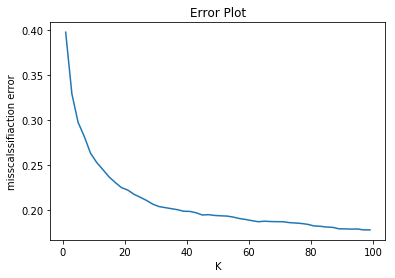

In [36]:
error_plot(neighbours,mse)
print("Best value of K found for KD Tree Algorithm Implementaion is : ",best_k)

#### 9.2.2 Training the model

In [37]:
neigh = KNeighborsClassifier(n_neighbors = best_k,algorithm='kd_tree')
neigh.fit(X1_train_bow, y1_train)

KNeighborsClassifier(algorithm='kd_tree', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=97, p=2,
           weights='uniform')

#### 9.2.3 Evaluting the performance of model

##### (A). Roc-Auc Plot

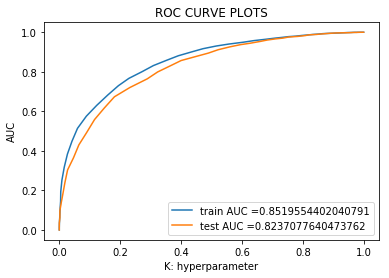

In [38]:
plot_auc_roc(neigh,X1_train_bow,X1_test_bow,y1_train,y1_test)

##### (B). Confusion Matrix Plot on Train Data

Confusion Matrix for Train set


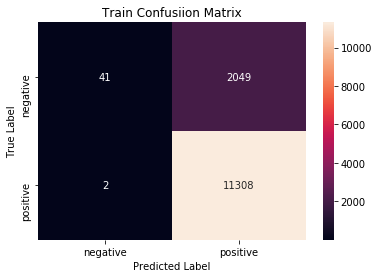

In [39]:
trainconfusionmatrix(neigh,X1_train_bow,y1_train)

##### (C). Confusion Matrix Plot on Test Data

Confusion Matrix for Test set


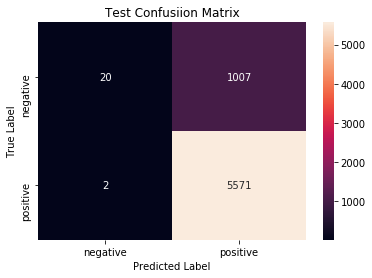

In [40]:
testconfusionmatrix(neigh,X1_test_bow,y1_test)

##### (D). Classification Report

In [41]:
print("Classification Report: \n")
prediction=neigh.predict(X1_test_bow)
print(classification_report(y1_test, prediction))

Classification Report: 

              precision    recall  f1-score   support

           0       0.91      0.02      0.04      1027
           1       0.85      1.00      0.92      5573

   micro avg       0.85      0.85      0.85      6600
   macro avg       0.88      0.51      0.48      6600
weighted avg       0.86      0.85      0.78      6600



# 10.0 TF-IDF

In [42]:
vectorizer = TfidfVectorizer(ngram_range=(1,2))
vectorizer.fit(X_train) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_TF = vectorizer.transform(X_train)
X_train_TF= preprocessing.normalize(X_train_TF)

X_test_TF = vectorizer.transform(X_test)
X_test_TF= preprocessing.normalize(X_test_TF)

In [43]:
print("After vectorizations")
print(X_train_TF.shape, y_train.shape)
print(X_test_TF.shape, y_test.shape)

After vectorizations
(33500, 584692) (33500,)
(16500, 584692) (16500,)


### 10.1 Brute Force Algorithm

#### 10.1.1 Finding Optimal Value of Hyperparameter(k)

In [44]:
import numpy as np 

neighbours=np.arange(1,100,2)
mse,best_k = knn_cv_brute(X_train_TF,y_train,neighbours)

Best value of K found for Brute Force Algorithm Implementaion is :  99


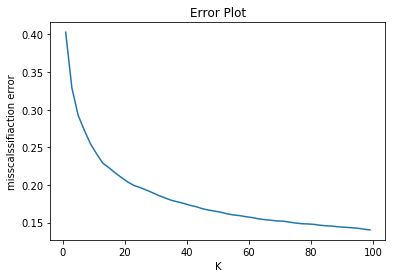

In [45]:
error_plot(neighbours,mse)
print("Best value of K found for Brute Force Algorithm Implementaion is : ",best_k)

##### 10.1.2 Training the model 

In [46]:
neigh = KNeighborsClassifier(n_neighbors = best_k,algorithm='brute')
neigh.fit(X_train_TF, y_train)

KNeighborsClassifier(algorithm='brute', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=99, p=2,
           weights='uniform')

#### 10.1.3 Evaluting the performance of model

##### (A). Roc-Auc Plot

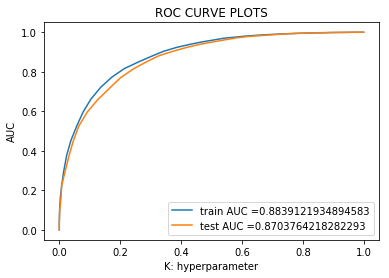

In [47]:
plot_auc_roc(neigh,X_train_TF,X_test_TF,y_train,y_test)

##### (B). Confusion Matrix Plot on Train Data

Confusion Matrix for Train set


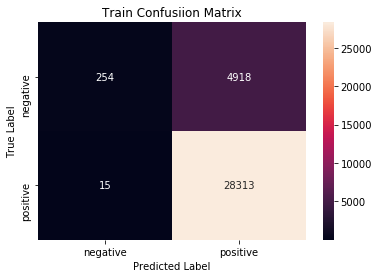

In [48]:
trainconfusionmatrix(neigh,X_train_TF,y_train)

##### (C). Confusion Matrix Plot on Test Data

Confusion Matrix for Test set


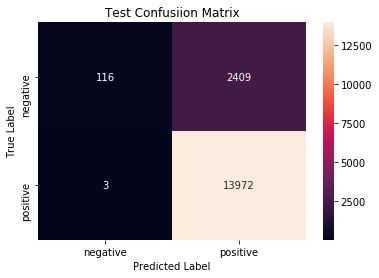

In [49]:
testconfusionmatrix(neigh,X_test_TF,y_test)

##### (D). Classification Report

In [50]:
print("Classification Report: \n")
prediction=neigh.predict(X_test_TF)
print(classification_report(y_test, prediction))

Classification Report: 

              precision    recall  f1-score   support

           0       0.97      0.05      0.09      2525
           1       0.85      1.00      0.92     13975

   micro avg       0.85      0.85      0.85     16500
   macro avg       0.91      0.52      0.50     16500
weighted avg       0.87      0.85      0.79     16500



### 10.2 KD Tree Algorithm

#### 10.2.1 Finding Optimal Value of Hyperparameter(k)

In [51]:
vectorizer = TfidfVectorizer(ngram_range=(1,2))
vectorizer.fit(X1_train) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X1_train_TF = vectorizer.transform(X1_train)
X1_train_TF= preprocessing.normalize(X1_train_TF)

X1_test_TF = vectorizer.transform(X1_test)
X1_test_TF= preprocessing.normalize(X1_test_TF)

In [52]:
import numpy as np 

neighbours=np.arange(1,100,2)
mse,best_k = knn_cv_kd(X1_train_TF,y1_train,neighbours)

Best value of K found for KD Tree Algorithm Implementaion is :  99


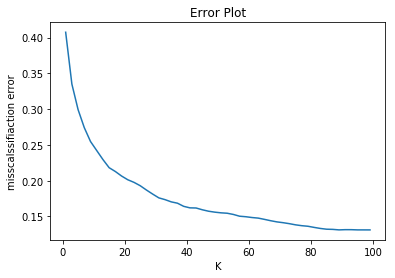

In [53]:
error_plot(neighbours,mse)
print("Best value of K found for KD Tree Algorithm Implementaion is : ",best_k)

##### 10.2.2 Training the model

In [54]:
neigh = KNeighborsClassifier(n_neighbors = best_k,algorithm='kd_tree')
neigh.fit(X1_train_TF, y1_train)

KNeighborsClassifier(algorithm='kd_tree', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=99, p=2,
           weights='uniform')

##### 10.2.3 Evaluting the performance of model

##### (A). Roc-Auc Plot

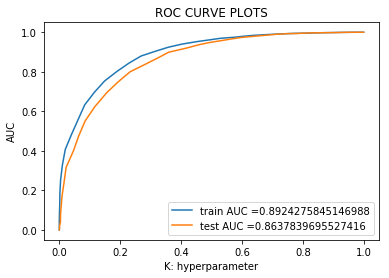

In [55]:
plot_auc_roc(neigh,X1_train_TF,X1_test_TF,y1_train,y1_test)

###### (B). Confusion Matrix Plot on Train Data

Confusion Matrix for Train set


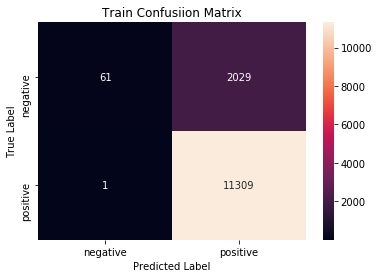

In [56]:
trainconfusionmatrix(neigh,X1_train_TF,y1_train)

##### (C). Confusion Matrix Plot on Test Data

Confusion Matrix for Test set


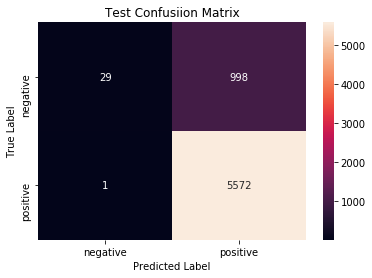

In [57]:
testconfusionmatrix(neigh,X1_test_TF,y1_test)

##### (D). Classification Report

In [58]:
print("Classification Report: \n")
prediction=neigh.predict(X1_test_TF)
print(classification_report(y1_test, prediction))

Classification Report: 

              precision    recall  f1-score   support

           0       0.97      0.03      0.05      1027
           1       0.85      1.00      0.92      5573

   micro avg       0.85      0.85      0.85      6600
   macro avg       0.91      0.51      0.49      6600
weighted avg       0.87      0.85      0.78      6600



# 11.0 Word To Vector

In [59]:
list_of_Train_sent=[]
list_of_Test_sent=[]

for sent in X_train:
    list_of_Train_sent.append(sent.split())
    
for sent in X_test:
    list_of_Test_sent.append(sent.split())

In [60]:
len(list_of_Train_sent)

33500

In [61]:
model=Word2Vec(list_of_Train_sent,min_count=5,size=50, workers=4)

### 11.1 Avg Word2Vec


In [62]:
import numpy as np

Train_vectors = []
for sent in list_of_Train_sent:
    sent_vec = np.zeros(50)
    cnt_words = 0
    for word in sent:
        try:
            vec = model.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    if cnt_words!=0:    
        sent_vec /= cnt_words
    Train_vectors.append(sent_vec)
Train_vectors = np.nan_to_num(Train_vectors)

In [63]:
import numpy as np

Test_vectors=[]
for sent in list_of_Test_sent:
    sent_vec=np.zeros(50)
    cnt_words=0
    for word in sent:
        try:
            vec=model.wv[word]
            sent_vec+=vec
            cnt_words+=1
        except:
            pass
    if cnt_words!=0:
        sent_vec/=cnt_words
    Test_vectors.append(sent_vec)
Test_vectors=np.nan_to_num(Test_vectors)    

In [64]:
print("Shape of Test Vectors : ",Test_vectors.shape)

Shape of Test Vectors :  (16500, 50)


In [65]:
X_train_AWV = Train_vectors
X_test_AWV = Test_vectors

In [66]:
print(X_train_AWV.shape, y_train.shape)
print(X_test_AWV.shape, y_test.shape)

(33500, 50) (33500,)
(16500, 50) (16500,)


### 10.2 Brute Force Algorithm

#### 10.2.1 Finding Optimal Value of Hyperparameter(k)

In [67]:
import numpy as np 

neighbours=np.arange(1,100,2)
mse,best_k = knn_cv_brute(X_train_AWV,y_train,neighbours)

Best value of K found for Brute Force Algorithm Implementaion is :  99


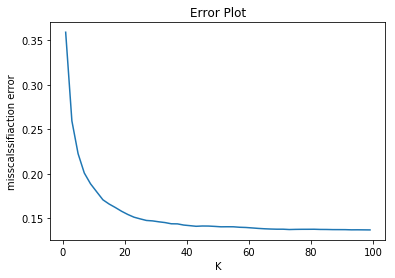

In [68]:
error_plot(neighbours,mse)
print("Best value of K found for Brute Force Algorithm Implementaion is : ",best_k)

#### 10.2.2 Training the model

In [69]:
neigh = KNeighborsClassifier(n_neighbors = best_k,algorithm='brute')
neigh.fit(X_train_AWV, y_train)

KNeighborsClassifier(algorithm='brute', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=99, p=2,
           weights='uniform')

##### 10.2.3 Evaluting the performance of model

##### (A). Roc-Auc Plot

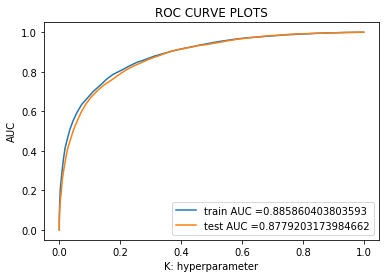

In [70]:
plot_auc_roc(neigh,X_train_AWV,X_test_AWV,y_train,y_test)

##### (B). Confusion Matrix Plot on Train Data

Confusion Matrix for Train set


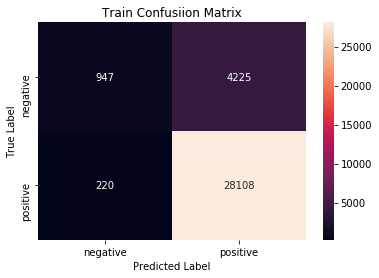

In [71]:
trainconfusionmatrix(neigh,X_train_AWV,y_train)

##### (C). Confusion Matrix Plot on Test Data

Confusion Matrix for Test set


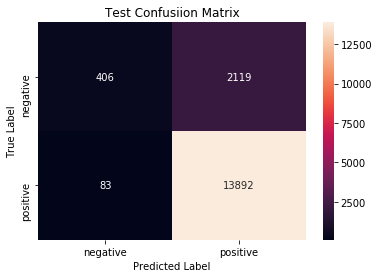

In [72]:
testconfusionmatrix(neigh,X_test_AWV,y_test)

#### (D). Classification Report

In [73]:
print("Classification Report: \n")
prediction=neigh.predict(X_test_AWV)
print(classification_report(y_test, prediction))

Classification Report: 

              precision    recall  f1-score   support

           0       0.83      0.16      0.27      2525
           1       0.87      0.99      0.93     13975

   micro avg       0.87      0.87      0.87     16500
   macro avg       0.85      0.58      0.60     16500
weighted avg       0.86      0.87      0.83     16500



### 10.3 KD Tree Algorithm

In [74]:
list_of_Train_sent1=[]
list_of_Test_sent1=[]

for sent in X1_train:
    list_of_Train_sent1.append(sent.split())
    
for sent in X1_test:
    list_of_Test_sent1.append(sent.split())

In [75]:
Train_model1=Word2Vec(list_of_Train_sent1,min_count=5,size=50, workers=4)

In [76]:
import numpy as np

Train_vectors1 = []
for sent in list_of_Train_sent1:
    sent_vec = np.zeros(50)
    cnt_words = 0
    for word in sent:
        try:
            vec = Train_model1.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    if cnt_words!=0:    
        sent_vec /= cnt_words
    Train_vectors1.append(sent_vec)
Train_vectors1 = np.nan_to_num(Train_vectors1)

In [77]:
Train_vectors1.shape

(13400, 50)

In [78]:
import numpy as np

Test_vectors1=[]
for sent in list_of_Test_sent1:
    sent_vec=np.zeros(50)
    cnt_words=0
    for word in sent:
        try:
            vec=Train_model1.wv[word]
            sent_vec+=vec
            cnt_words+=1
        except:
            pass
    if cnt_words!=0:
        sent_vec/=cnt_words
    Test_vectors1.append(sent_vec)
Test_vectors1=np.nan_to_num(Test_vectors1)    

In [79]:
Test_vectors1.shape

(6600, 50)

In [80]:
X_train_AWV1 = Train_vectors1
X_test_AWV1 = Test_vectors1

#### 10.3.1 Finding Optimal Value of Hyperparameter(k)

In [81]:
import numpy as np 

neighbours=np.arange(1,100,2)
mse,best_k = knn_cv_kd(X_train_AWV1,y1_train,neighbours)

Best value of K found for KD Tree Algorithm Implementaion is :  95


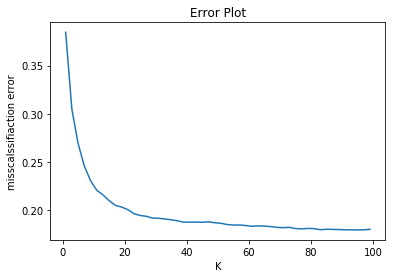

In [82]:
error_plot(neighbours,mse)
print("Best value of K found for KD Tree Algorithm Implementaion is : ",best_k)

#### 10.3.2 Training the model

In [83]:
neigh = KNeighborsClassifier(n_neighbors = best_k,algorithm='kd_tree')
neigh.fit(X_train_AWV1, y1_train)

KNeighborsClassifier(algorithm='kd_tree', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=95, p=2,
           weights='uniform')

#### 10.3.3 Evaluting the performance of model

##### (A). Roc-Auc Plot

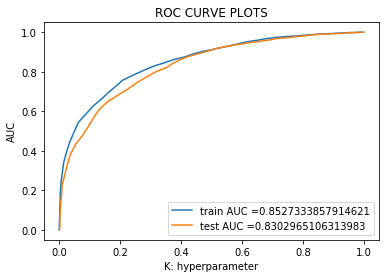

In [84]:
plot_auc_roc(neigh,X_train_AWV1,X_test_AWV1,y1_train,y1_test)

##### (B). Confusion Matrix Plot on Train Data

Confusion Matrix for Train set


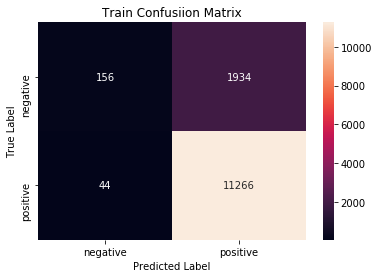

In [85]:
trainconfusionmatrix(neigh,X_train_AWV1,y1_train)

##### (C). Confusion Matrix Plot on Test Data

Confusion Matrix for Test set


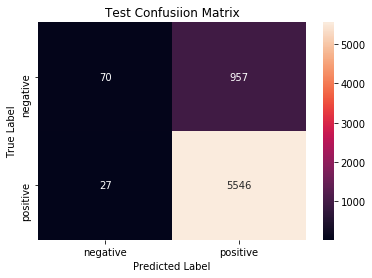

In [86]:
testconfusionmatrix(neigh,X_test_AWV1,y1_test)

##### (D). Classification Report

In [87]:
print("Classification Report: \n")
prediction=neigh.predict(X_test_AWV1)
print(classification_report(y1_test, prediction))

Classification Report: 

              precision    recall  f1-score   support

           0       0.72      0.07      0.12      1027
           1       0.85      1.00      0.92      5573

   micro avg       0.85      0.85      0.85      6600
   macro avg       0.79      0.53      0.52      6600
weighted avg       0.83      0.85      0.79      6600



# 11.0 TF-IDF Word To Vector

In [88]:
model_TF = TfidfVectorizer()
model_TF.fit(X_train)
X_Train_TF = model_TF.transform(X_train)
X_Test_TF = model_TF.transform(X_test)

In [89]:
print("Shape of Train Data After TFIDF : ",X_Train_TF.shape)
print("Shape of Test Data After TFIDF : ",X_Test_TF.shape)

Shape of Train Data After TFIDF :  (33500, 22818)
Shape of Test Data After TFIDF :  (16500, 22818)


In [90]:
TFIDF_Feature=model_TF.get_feature_names()
print(len(TFIDF_Feature))
print(TFIDF_Feature[0:20])

22818
['aaaaaah', 'aaaaaahhhhhyaaaaaa', 'aaah', 'aaahhh', 'aadp', 'aadult', 'aafco', 'aahhh', 'aarp', 'ab', 'aback', 'abandon', 'abat', 'abbey', 'abbi', 'abbott', 'abbrevi', 'abc', 'abdomen', 'abdomin']


In [91]:
from tqdm import tqdm
Train_TFIDF_W2V_Vectors=[]
row=0
for sent in tqdm(list_of_Train_sent):
    sent_vec=np.zeros(50)
    weight=0
    for word in sent:
        try :
            w2v_vec=model.wv[word]
            tfidf_vec=X_Train_TF[row,TFIDF_Feature.index(word)]
            sent_vec+=(w2v_vec*tfidf_vec)
            weight+=tfidf_vec
            
        except :
            pass
    if weight!=0:
        sent_vec/=weight
    Train_TFIDF_W2V_Vectors.append(sent_vec) 
    row+=1

100%|████████████████████████████████████| 33500/33500 [11:08<00:00, 50.09it/s]


In [92]:
Test_TFIDF_W2V_Vectors=[]
row=0
for sent in tqdm(list_of_Test_sent):
    sent_vec=np.zeros(50)
    weight=0
    
    for word in sent:
        try:
            w2v_vec=model.wv[word]
            tfidf_vec=X_Test_TF(row,TFIDF_Feature.index(word))
            sent_vec+=(w2v_vec*tfidf_vec)
            weight+=tfidf
          
        except :
            pass
    
    if weight!=0:
        sent_vec/=weight
    Test_TFIDF_W2V_Vectors.append(sent_vec)    
    row+=1

100%|████████████████████████████████████| 16500/16500 [04:12<00:00, 65.33it/s]


In [93]:
Test_tfidfw2v_vectors=np.nan_to_num(Test_TFIDF_W2V_Vectors)  
Train_tfidfw2v_vectors=np.nan_to_num(Train_TFIDF_W2V_Vectors)  

In [94]:
X_train_TfIdfW2v=Train_tfidfw2v_vectors
X_test_TfIdfW2v=Test_tfidfw2v_vectors

### 11.1 Brute Force Algorithm

#### 11.1.1 Finding Optimal Value of Hyperparameter(k) 

In [95]:
import numpy as np 

neighbours=np.arange(1,100,2)
mse,best_k = knn_cv_brute(X_train_TfIdfW2v,y_train,neighbours)

Best value of K found for Brute Force Algorithm Implementaion is :  99


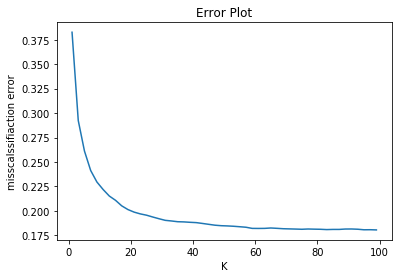

In [96]:
error_plot(neighbours,mse)
print("Best value of K found for Brute Force Algorithm Implementaion is : ",best_k)

#### 11.1.2 Training the model

In [97]:
neigh = KNeighborsClassifier(n_neighbors = best_k,algorithm='brute')
neigh.fit(X_train_TfIdfW2v, y_train)

KNeighborsClassifier(algorithm='brute', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=99, p=2,
           weights='uniform')

#### 11.1.3 Evaluting the performance of model

##### (A). Roc-Auc Plot

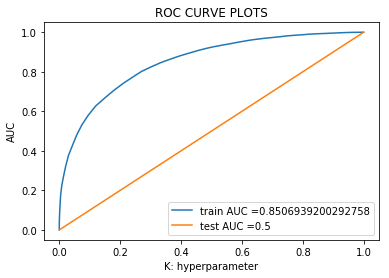

In [98]:
plot_auc_roc(neigh,X_train_TfIdfW2v,X_test_TfIdfW2v,y_train,y_test)

##### (B). Confusion Matrix Plot on Train Data

Confusion Matrix for Train set


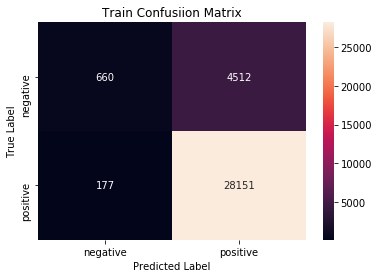

In [99]:
trainconfusionmatrix(neigh,X_train_TfIdfW2v,y_train)

##### (C). Confusion Matrix Plot on Test Data

Confusion Matrix for Test set


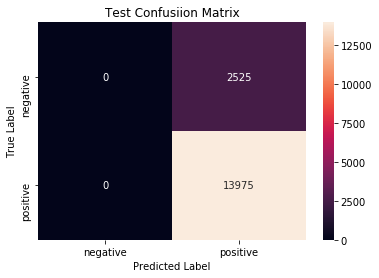

In [100]:
testconfusionmatrix(neigh,X_test_TfIdfW2v,y_test)

##### (D). Classification Report

In [101]:
print("Classification Report: \n")
prediction=neigh.predict(X_test_TfIdfW2v)
print(classification_report(y_test, prediction))

Classification Report: 

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      2525
           1       0.85      1.00      0.92     13975

   micro avg       0.85      0.85      0.85     16500
   macro avg       0.42      0.50      0.46     16500
weighted avg       0.72      0.85      0.78     16500



### 11.2 KD Tree Algorithm

In [102]:
model_TF1 = TfidfVectorizer()
model_TF1.fit(X_train)
X_Train_TF1 = model_TF1.transform(X1_train)
X_Test_TF1 = model_TF1.transform(X1_test)

In [103]:
print("Shape of Train Data After TFIDF : ",X_Train_TF1.shape)
print("Shape of Test Data After TFIDF : ",X_Test_TF1.shape)

Shape of Train Data After TFIDF :  (13400, 22818)
Shape of Test Data After TFIDF :  (6600, 22818)


In [104]:
TFIDF_Feature1=model_TF1.get_feature_names()
print(len(TFIDF_Feature1))
print(TFIDF_Feature1[0:20])

22818
['aaaaaah', 'aaaaaahhhhhyaaaaaa', 'aaah', 'aaahhh', 'aadp', 'aadult', 'aafco', 'aahhh', 'aarp', 'ab', 'aback', 'abandon', 'abat', 'abbey', 'abbi', 'abbott', 'abbrevi', 'abc', 'abdomen', 'abdomin']


In [105]:
from tqdm import tqdm
Train_TFIDF_W2V_Vectors1=[]
row=0
for sent in tqdm(list_of_Train_sent1):
    sent_vec=np.zeros(50)
    weight=0
    for word in sent:
        try :
            w2v_vec=Train_model1.wv[word]
            tfidf_vec=X_Train_TF1[row,TFIDF_Feature1.index(word)]
            sent_vec+=(w2v_vec*tfidf_vec)
            weight+=tfidf_vec
            
        except :
            pass
    if weight!=0:
        sent_vec/=weight
    Train_TFIDF_W2V_Vectors1.append(sent_vec) 
    row+=1

100%|████████████████████████████████████| 13400/13400 [04:14<00:00, 52.57it/s]


In [106]:
Test_TFIDF_W2V_Vectors1=[]
row=0
for sent in tqdm(list_of_Test_sent1):
    sent_vec=np.zeros(50)
    weight=0
    
    for word in sent:
        try:
            w2v_vec=Train_model1.wv[word]
            tfidf_vec=X_Test_TF1(row,TFIDF_Feature1.index(word))
            sent_vec+=(w2v_vec*tfidf_vec)
            weight+=tfidf
          
        except :
            pass
    
    if weight!=0:
        sent_vec/=weight
    Test_TFIDF_W2V_Vectors1.append(sent_vec)    
    row+=1

100%|██████████████████████████████████████| 6600/6600 [01:30<00:00, 73.22it/s]


In [107]:
Test_tfidfw2v_vectors1=np.nan_to_num(Test_TFIDF_W2V_Vectors1)  
Train_tfidfw2v_vectors1=np.nan_to_num(Train_TFIDF_W2V_Vectors1)  

In [108]:
X_train_TfIdfW2v1=Train_tfidfw2v_vectors1
X_test_TfIdfW2v1=Test_tfidfw2v_vectors1

#### 11.2.1 Finding Optimal Value of Hyperparameter(k)

In [109]:
import numpy as np 

neighbours=np.arange(1,100,2)
mse,best_k = knn_cv_kd(X_train_TfIdfW2v1,y1_train,neighbours)

Best value of K found for KD Tree Algorithm Implementaion is :  97


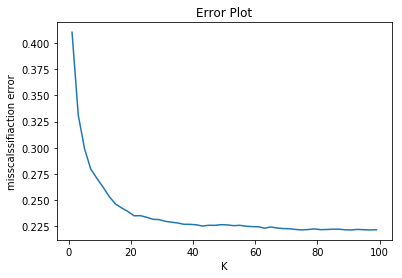

In [110]:
error_plot(neighbours,mse)
print("Best value of K found for KD Tree Algorithm Implementaion is : ",best_k)

#### 11.2.2 Training the model

In [111]:
neigh = KNeighborsClassifier(n_neighbors = best_k,algorithm='kd_tree')
neigh.fit(X_train_TfIdfW2v1, y1_train)

KNeighborsClassifier(algorithm='kd_tree', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=97, p=2,
           weights='uniform')

#### 11.2.3 Evaluting the performance of model

##### (A). Roc-Auc Plot

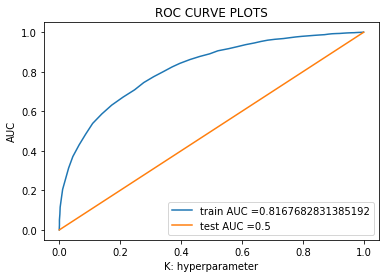

In [112]:
plot_auc_roc(neigh,X_train_TfIdfW2v1,X_test_TfIdfW2v1,y1_train,y1_test)

##### (B). Confusion Matrix Plot on Train Data

Confusion Matrix for Train set


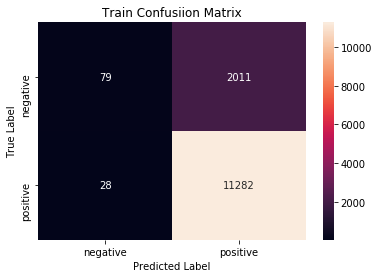

In [113]:
trainconfusionmatrix(neigh,X_train_TfIdfW2v1,y1_train)

##### (C). Confusion Matrix Plot on Test Data

Confusion Matrix for Test set


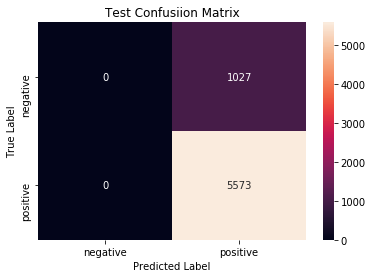

In [114]:
testconfusionmatrix(neigh,X_test_TfIdfW2v1,y1_test)

##### (D). Classification Report

In [115]:
print("Classification Report: \n")
prediction=neigh.predict(X_test_TfIdfW2v1)
print(classification_report(y1_test, prediction))

Classification Report: 

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1027
           1       0.84      1.00      0.92      5573

   micro avg       0.84      0.84      0.84      6600
   macro avg       0.42      0.50      0.46      6600
weighted avg       0.71      0.84      0.77      6600



# 12.0 Conclusion :

#### 1. Report On Brute Force Algorithm

In [116]:
from prettytable import PrettyTable
    
x = PrettyTable()

x.field_names = ["Vectorizer", "Hyperparameter","Train AUC","Test AUC","F1-Score"]

x.add_row(["BOW",95,0.86,0.83,0.79])
x.add_row(["TF-IDF",99,0.88,0.87,0.79])
x.add_row(["W2V",99,0.88,0.87,0.83])
x.add_row(["TF-IDF W2V",99,0.85,0.50,0.78])
print(x)

+------------+----------------+-----------+----------+----------+
| Vectorizer | Hyperparameter | Train AUC | Test AUC | F1-Score |
+------------+----------------+-----------+----------+----------+
|    BOW     |       95       |    0.86   |   0.83   |   0.79   |
|   TF-IDF   |       99       |    0.88   |   0.87   |   0.79   |
|    W2V     |       99       |    0.88   |   0.87   |   0.83   |
| TF-IDF W2V |       99       |    0.85   |   0.5    |   0.78   |
+------------+----------------+-----------+----------+----------+


##### 2. Report on KD Tree Algorithm

In [117]:
x = PrettyTable()

x.field_names = ["Vectorizer","Hyperparameter","Train AUC","Test AUC","F1-Score"]

x.add_row(["BOW",97,0.85,0.82,0.78])
x.add_row(["TF-IDF",99,0.89,0.86,0.78])
x.add_row(["W2V",95,0.85,0.83,0.79])
x.add_row(["TF-IDF W2V",97,0.81,0.50,0.75])
print(x)

+------------+----------------+-----------+----------+----------+
| Vectorizer | Hyperparameter | Train AUC | Test AUC | F1-Score |
+------------+----------------+-----------+----------+----------+
|    BOW     |       97       |    0.85   |   0.82   |   0.78   |
|   TF-IDF   |       99       |    0.89   |   0.86   |   0.78   |
|    W2V     |       95       |    0.85   |   0.83   |   0.79   |
| TF-IDF W2V |       97       |    0.81   |   0.5    |   0.75   |
+------------+----------------+-----------+----------+----------+


#### 3. BOW and TF-IDF are giving same result of Hyperparameter,F1-Score,Train-AUC and Test-AUC.

#### 4. The KD-Tree and Brute Force implementation of KNN gives relatively similar results.

#### 5. Very small subset of Data is  taken but still it took more time due to large dimension and time complexity of KNN.

#### 6. Model behaviour in TF-IDF W2V is lenint towards one class .